In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from srresnet import _NetG
from srresnet import PatchGan as _NetD

from util.visualizer import Visualizer

from collections import OrderedDict
from util.image_pool import ImagePool

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as tf
from torch.utils.data import Dataset, DataLoader
from torch import autograd

In [3]:
class SRDataset(Dataset):
    def __init__(self,root, cropsize=512, downsample_factor=4):
        self.imagefolder = ImageFolder(root,transform=tf.RandomCrop(cropsize))
        self.cropsize = cropsize
        self.ds_size = int(cropsize/downsample_factor)
    
    def __len__(self):
        return len(self.imagefolder)
    def __getitem__(self,idx):
        HR_img,_ = self.imagefolder[idx]
        LR_img = tf.Resize(size=self.ds_size)(HR_img)
        tt = tf.ToTensor()
        return (tt(LR_img),tt(HR_img))
    

In [4]:
import argparse
import math, random
import os, time

In [5]:
# Training settings
parser = argparse.ArgumentParser(description="PyTorch SRResNet")


parser.add_argument("--name",type=str,default="experiment_name",help="Where to store checkpoint data")
parser.add_argument("--checkpoints_dir",type=str,default='./checkpoint/')

#parser.add_argument("--save_freq",type=int,default=5,help="Save frequency")
parser.add_argument("--batch_size", type=int, default=16, help="training batch size")
parser.add_argument("--nEpochs", type=int, default=500, help="number of epochs to train for")
parser.add_argument("--lr", type=float, default=1e-4, help="Learning Rate. Default=1e-4")
parser.add_argument("--step", type=int, default=200, help="Sets the learning rate to the initial LR decayed by momentum every n epochs, Default: n=500")
parser.add_argument("--cuda", action="store_false", help="Use cuda?")
#parser.add_argument("--resume", default="", type=str, help="Path to checkpoint (default: none)")
parser.add_argument("--start-epoch", default=1, type=int, help="Manual epoch number (useful on restarts)")
parser.add_argument("--threads", type=int, default=0, help="Number of threads for data loader to use, Default: 1")
parser.add_argument("--pretrained", default="", type=str, help="path to pretrained model (default: none)")
parser.add_argument("--vgg_loss", action="store_true", help="Use content loss?")
parser.add_argument("--gpu_ids", default="0", type=str, help="gpu ids (default: 0)")
parser.add_argument("--isTrain",action="store_true",help="Train mode")
parser.add_argument("--lambda_l1",default=1e-3,type=float,help="Sets content loss lambda parameter")

parser.add_argument('--save_latest_freq', type=int, default=5000, help='frequency of saving the latest results')
parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
parser.add_argument('--continue_train', action='store_true', help='continue training: load the latest model')
parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')


# Visualizer Settings
parser.add_argument('--display_freq', type=int, default=160, help='frequency of showing training results on screen')
parser.add_argument('--display_ncols', type=int, default=3, help='if positive, display all images in a single visdom web panel with certain number of images per row.')
parser.add_argument('--display_id', type=int, default=1, help='window id of the web display')
parser.add_argument('--display_server', type=str, default="http://localhost", help='visdom server of the web display')
parser.add_argument('--display_env', type=str, default='main', help='visdom display environment name (default is "main")')
parser.add_argument('--display_port', type=int, default=5500, help='visdom port of the web display')
parser.add_argument('--update_html_freq', type=int, default=400, help='frequency of saving training results to html')
parser.add_argument('--print_freq', type=int, default=80, help='frequency of showing training results on console')
parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')

parser.add_argument('--no_html', action='store_true', help='do not save intermediate training results to [opt.checkpoints_dir]/[opt.name]/web/')

# WGAN settings
parser.add_argument('--use_d_norm',action='store_false',help='Use norm in Discriminator')
parser.add_argument('--use_g_norm',action='store_false',help='Use norm in Generator')
parser.add_argument('--lambda_grad',default=10,type=float,help='Sets Wasserstein GANs gradient lambda')


_StoreAction(option_strings=['--lambda_grad'], dest='lambda_grad', nargs=None, const=None, default=10, type=<class 'float'>, choices=None, help='Sets Wasserstein GANs gradient lambda', metavar=None)

In [6]:
class GANLoss(nn.Module):
    """Define different GAN objectives.
    The GANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, gan_mode, target_real_label=1.0, target_fake_label=0.0):
        """ Initialize the GANLoss class.
        Parameters:
            gan_mode (str) - - the type of GAN objective. It currently supports vanilla, lsgan, and wgangp.
            target_real_label (bool) - - label for a real image
            target_fake_label (bool) - - label of a fake image
        Note: Do not use sigmoid as the last layer of Discriminator.
        LSGAN needs no sigmoid. vanilla GANs will handle it with BCEWithLogitsLoss.
        """
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.gan_mode = gan_mode
        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode in ['wgangp']:
            self.loss = None
        else:
            raise NotImplementedError('gan mode %s not implemented' % gan_mode)

    def get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.
        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.
        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images
        Returns:
            the calculated loss.
        """
        if self.gan_mode in ['lsgan', 'vanilla']:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            loss = self.loss(prediction, target_tensor)
        elif self.gan_mode == 'wgangp':
            if target_is_real:
                loss = -prediction.mean()
            else:
                loss = prediction.mean()
        return loss


class SR_WGANS(nn.Module):
    def __init__(self,opt):
        super().__init__()
        self.opt = opt
        
        self.gpu_ids = opt.gpu_ids
        self.isTrain = opt.isTrain
        self.device = torch.device('cuda:{}'.format(self.gpu_ids[0])) if self.gpu_ids else torch.device('cpu') 
        self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)  # save all the checkpoints to save_dir
        
        
        # Create Networks
        self.netG = _NetG(norm=opt.use_g_norm).to(self.device)
        
        self.model_names = ['G']
        
        # Visual Names
        self.visual_names = ['bicubic','hr','sr']
        
        if self.isTrain:
            self.netD = _NetD(use_norm=opt.use_d_norm).to(self.device)
            self.model_names.append('D')
            
            # Define Losses
            self.criterionL1 = torch.nn.L1Loss()
            self.criterionGAN = GANLoss('lsgan').to(self.device)
            
            self.loss_names = ['L1','D','GAN','D_grad']
            
            # Define Optimizers
            self.optimizer_G = torch.optim.Adam(self.netG.parameters(), lr=opt.lr)
            self.optimizer_D = torch.optim.Adam(self.netD.parameters(), lr=opt.lr)
            
            self.sr_pool = ImagePool(25)

    
    def set_requires_grad(self, nets, requires_grad=False):
        """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
        Parameters:
            nets (network list)   -- a list of networks
            requires_grad (bool)  -- whether the networks require gradients or not
        """
        if not isinstance(nets, list):
            nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad
    
    def set_input(self,input):
        lr,hr = input
        self.lr = lr.to(self.device)
        self.hr = hr.to(self.device)
        
    def forward(self):
        self.sr = self.netG(self.lr)
    
    def calc_gradient_penalty(self, real_data, fake_data):
        BATCH_SIZE, NUM_CH, DIM, _ = real_data.size()
        alpha = torch.rand(BATCH_SIZE,1)
        alpha = alpha.expand(BATCH_SIZE, int(real_data.nelement()/BATCH_SIZE)).contiguous()
        alpha = alpha.view(BATCH_SIZE, NUM_CH, DIM, DIM)
        alpha = alpha.to(self.device)

        interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

        interpolates = interpolates.to(self.device)
        interpolates.requires_grad_(True)   

        disc_interpolates = self.netD(interpolates).mean(dim=(1,2,3))

        gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).to(self.device),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

        gradients = gradients.view(gradients.size(0), -1)                              
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * self.opt.lambda_grad
        return gradient_penalty

    def backward_D(self):
        # Calculate discriminator loss
        
        # Real
        pred_real = self.netD(self.hr)
        loss_D_real = pred_real.mean()#self.criterionGAN(pred_real,True)
        
        # Fake
        sr = self.sr_pool.query(self.sr)
        pred_fake = self.netD(sr)
        loss_D_fake = pred_fake.mean() #self.criterionGAN(pred_fake, False)
        
        #self.loss_D = loss_D_real + loss_D_fake
        
        # Calculate gradients
        self.loss_D_grad = self.calc_gradient_penalty(self.hr, sr)
        
        # Calculate final loss
        self.loss_D = loss_D_fake - loss_D_real + self.loss_D_grad

        self.loss_D.backward()
        #return loss_D

    def backward_G(self):
        # GAN loss
        self.loss_GAN = -self.netD(self.sr).mean()#self.criterionGAN(self.netD(self.sr),True)
        
        # Content Loss
        self.loss_L1 = self.criterionL1(self.sr,self.hr)*self.opt.lambda_l1
        
        # Calculate Gradients
        self.loss_G = self.loss_GAN + self.loss_L1
        self.loss_G.backward()
        
    def optimize_parameters(self):
        # forward
        self.forward()
        
        # G
        self.set_requires_grad(self.netD,False)
        self.optimizer_G.zero_grad()
        self.backward_G()
        self.optimizer_G.step()
        
        # D
        self.set_requires_grad(self.netD,True)
        self.backward_D()
        self.optimizer_D.step()
        
    def save_networks(self, epoch):
        """Save all the networks to the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                save_filename = '%s_net_%s.pth' % (epoch, name)
                save_path = os.path.join(self.save_dir, save_filename)
                net = getattr(self, 'net' + name)

                if len(self.gpu_ids) > 0 and torch.cuda.is_available():
                    torch.save(net.cpu().state_dict(), save_path)
                    net.to(self.device)
                else:
                    torch.save(net.cpu().state_dict(), save_path)
                    
    def load_networks(self, epoch):
        """Load all the networks from the disk.
        Parameters:
            epoch (int) -- current epoch; used in the file name '%s_net_%s.pth' % (epoch, name)
        """
        for name in self.model_names:
            if isinstance(name, str):
                load_filename = '%s_net_%s.pth' % (epoch, name)
                load_path = os.path.join(self.save_dir, load_filename)
                net = getattr(self, 'net' + name)
                if isinstance(net, torch.nn.DataParallel):
                    net = net.module
                print('loading the model from %s' % load_path)
                # if you are using PyTorch newer than 0.4 (e.g., built from
                # GitHub source), you can remove str() on self.device
                state_dict = torch.load(load_path, map_location=str(self.device))
                if hasattr(state_dict, '_metadata'):
                    del state_dict._metadata

                # patch InstanceNorm checkpoints prior to 0.4
                for key in list(state_dict.keys()):  # need to copy keys here because we mutate in loop
                    self.__patch_instance_norm_state_dict(state_dict, net, key.split('.'))
                net.load_state_dict(state_dict)
    
    def compute_visuals(self):
        # Pull first image from each batch
        lr = self.lr[0].detach().cpu()
        hr = self.hr[0:1].detach().cpu()
        _,_,h,w = hr.size()
        
        bicubic_interp = tf.Compose([tf.ToPILImage(),tf.Resize(size=min(h,w),interpolation=3),tf.ToTensor()])
        self.bicubic = bicubic_interp(lr).unsqueeze(0)
        
        self.hr = hr
        self.sr = self.sr[0:1].detach().cpu()
        
    def get_current_visuals(self):
        """Return visualization images. train.py will display these images with visdom, and save the images to a HTML"""
        visual_ret = OrderedDict()
        for name in self.visual_names:
            if isinstance(name, str):
                visual_ret[name] = getattr(self, name)
        return visual_ret
    
    def get_current_losses(self):
        """Return traning losses / errors. train.py will print out these errors on console, and save them to a file"""
        errors_ret = OrderedDict()
        for name in self.loss_names:
            if isinstance(name, str):
                errors_ret[name] = float(getattr(self, 'loss_' + name))  # float(...) works for both scalar tensor and float number
        return errors_ret 

In [7]:
args = ['--name','SR_WGANs_1000','--isTrain', '--nEpochs','300','--gpu_ids','0','--lambda_l1','1000']

opt,_ = parser.parse_known_args(args)
print(opt)

dataset = SRDataset('./data/DIV2K_train_HR/')
training_data_loader = DataLoader(dataset=dataset, num_workers=opt.threads, batch_size=opt.batch_size, shuffle=True)
dataset_size = len(dataset)

Namespace(batch_size=16, checkpoints_dir='./checkpoint/', continue_train=False, cuda=True, display_env='main', display_freq=160, display_id=1, display_ncols=3, display_port=5500, display_server='http://localhost', display_winsize=256, epoch_count=1, gpu_ids='0', isTrain=True, lambda_grad=10, lambda_l1=1000.0, lr=0.0001, nEpochs=300, name='SR_WGANs_1000', no_html=False, pretrained='', print_freq=80, save_by_iter=False, save_epoch_freq=5, save_latest_freq=5000, start_epoch=1, step=200, threads=0, update_html_freq=400, use_d_norm=True, use_g_norm=True, vgg_loss=False)


In [8]:
model = SR_WGANS(opt)
visualizer = Visualizer(opt)

create web directory ./checkpoint/SR_WGANs_1000/web...


In [9]:
total_iters = 0                # the total number of training iterations

for epoch in range(opt.start_epoch, opt.nEpochs + 1):    # outer loop for different epochs; we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>
    epoch_start_time = time.time()  # timer for entire epoch
    iter_data_time = time.time()    # timer for data loading per iteration
    epoch_iter = 0                  # the number of training iterations in current epoch, reset to 0 every epoch

    for i, data in enumerate(training_data_loader):  # inner loop within one epoch
        iter_start_time = time.time()  # timer for computation per iteration
        if total_iters % opt.print_freq == 0:
            t_data = iter_start_time - iter_data_time
        visualizer.reset()
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)         # unpack data from dataset and apply preprocessing
        model.optimize_parameters()   # calculate loss functions, get gradients, update network weights

        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        if total_iters % opt.save_latest_freq == 0:   # cache our latest model every <save_latest_freq> iterations
            print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
            save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
            model.save_networks(save_suffix)

        iter_data_time = time.time()
    if epoch % opt.save_epoch_freq == 0:              # cache our model every <save_epoch_freq> epochs
        print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
        model.save_networks('latest')
        model.save_networks(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' % (epoch, opt.nEpochs, time.time() - epoch_start_time))

(epoch: 1, iters: 80, time: 0.190, data: 5.045) L1: 412.543 D: 9.638 GAN: 0.083 D_grad: 9.820 
(epoch: 1, iters: 160, time: 0.245, data: 4.426) L1: 283.311 D: 9.334 GAN: 0.093 D_grad: 9.592 
(epoch: 1, iters: 240, time: 0.191, data: 4.395) L1: 240.484 D: 9.019 GAN: 0.063 D_grad: 9.358 
(epoch: 1, iters: 320, time: 0.252, data: 3.703) L1: 225.381 D: 8.413 GAN: 0.040 D_grad: 8.845 
(epoch: 1, iters: 400, time: 0.191, data: 3.449) L1: 192.416 D: 7.404 GAN: 0.119 D_grad: 8.153 
(epoch: 1, iters: 480, time: 0.242, data: 2.911) L1: 163.989 D: 5.660 GAN: 0.141 D_grad: 6.555 
(epoch: 1, iters: 560, time: 0.191, data: 3.609) L1: 149.232 D: 2.410 GAN: 0.209 D_grad: 4.228 
(epoch: 1, iters: 640, time: 0.287, data: 3.160) L1: 149.141 D: 2.818 GAN: 0.780 D_grad: 3.941 
(epoch: 1, iters: 720, time: 0.189, data: 4.270) L1: 146.799 D: -0.288 GAN: 0.721 D_grad: 1.272 
(epoch: 1, iters: 800, time: 0.273, data: 3.998) L1: 115.257 D: 0.303 GAN: 0.580 D_grad: 0.931 
End of epoch 1 / 300 	 Time Taken: 281 s

(epoch: 9, iters: 240, time: 0.191, data: 4.155) L1: 57.452 D: 4.642 GAN: -1.515 D_grad: 2.222 
(epoch: 9, iters: 320, time: 0.276, data: 4.757) L1: 56.254 D: 4.410 GAN: -0.091 D_grad: 1.995 
(epoch: 9, iters: 400, time: 0.193, data: 5.563) L1: 60.982 D: 4.972 GAN: -0.269 D_grad: 1.890 
(epoch: 9, iters: 480, time: 0.275, data: 5.147) L1: 61.271 D: 4.688 GAN: -0.179 D_grad: 1.827 
(epoch: 9, iters: 560, time: 0.192, data: 5.310) L1: 42.115 D: 5.933 GAN: -0.232 D_grad: 1.915 
(epoch: 9, iters: 640, time: 0.273, data: 4.522) L1: 59.994 D: 2.924 GAN: -0.770 D_grad: 1.026 
(epoch: 9, iters: 720, time: 0.193, data: 4.967) L1: 53.183 D: 3.751 GAN: 0.142 D_grad: 1.549 
(epoch: 9, iters: 800, time: 0.310, data: 4.326) L1: 46.030 D: 3.492 GAN: -0.643 D_grad: 1.662 
End of epoch 9 / 300 	 Time Taken: 314 sec
(epoch: 10, iters: 80, time: 0.191, data: 4.173) L1: 50.205 D: 1.359 GAN: -1.799 D_grad: 1.425 
(epoch: 10, iters: 160, time: 0.282, data: 4.416) L1: 59.586 D: 5.063 GAN: 1.003 D_grad: 2.023

(epoch: 17, iters: 320, time: 0.546, data: 4.011) L1: 52.620 D: 6.818 GAN: 8.075 D_grad: 1.219 
(epoch: 17, iters: 400, time: 0.189, data: 4.220) L1: 50.960 D: 3.872 GAN: 6.037 D_grad: 0.731 
(epoch: 17, iters: 480, time: 0.351, data: 4.515) L1: 46.534 D: 5.665 GAN: 6.207 D_grad: 0.787 
(epoch: 17, iters: 560, time: 0.190, data: 3.912) L1: 52.719 D: 2.562 GAN: 7.036 D_grad: 0.480 
(epoch: 17, iters: 640, time: 0.327, data: 4.841) L1: 57.894 D: 2.613 GAN: 6.120 D_grad: 0.712 
(epoch: 17, iters: 720, time: 0.192, data: 6.189) L1: 53.698 D: 1.696 GAN: 5.169 D_grad: 0.681 
(epoch: 17, iters: 800, time: 0.265, data: 4.239) L1: 50.852 D: 5.283 GAN: 8.843 D_grad: 1.881 
End of epoch 17 / 300 	 Time Taken: 313 sec
(epoch: 18, iters: 80, time: 0.191, data: 4.713) L1: 54.819 D: 2.184 GAN: 3.503 D_grad: 1.360 
(epoch: 18, iters: 160, time: 0.288, data: 4.469) L1: 50.695 D: 6.871 GAN: 13.260 D_grad: 2.043 
(epoch: 18, iters: 240, time: 0.192, data: 4.485) L1: 47.697 D: 2.461 GAN: 7.427 D_grad: 1.3

(epoch: 25, iters: 400, time: 0.192, data: 4.289) L1: 50.800 D: 6.813 GAN: 22.098 D_grad: 0.492 
(epoch: 25, iters: 480, time: 0.313, data: 4.862) L1: 52.841 D: 3.132 GAN: 27.172 D_grad: 0.977 
(epoch: 25, iters: 560, time: 0.193, data: 4.203) L1: 58.501 D: 5.450 GAN: 26.092 D_grad: 0.891 
(epoch: 25, iters: 640, time: 0.332, data: 4.940) L1: 54.056 D: 5.071 GAN: 26.243 D_grad: 1.049 
(epoch: 25, iters: 720, time: 0.191, data: 4.204) L1: 55.848 D: 1.435 GAN: 27.345 D_grad: 1.003 
(epoch: 25, iters: 800, time: 0.317, data: 4.520) L1: 46.857 D: 4.035 GAN: 27.725 D_grad: 0.912 
saving the latest model (epoch 25, total_iters 20000)
saving the model at the end of epoch 25, iters 20000
End of epoch 25 / 300 	 Time Taken: 313 sec
(epoch: 26, iters: 80, time: 0.192, data: 4.693) L1: 47.667 D: 0.669 GAN: 26.229 D_grad: 0.673 
(epoch: 26, iters: 160, time: 0.283, data: 3.955) L1: 44.237 D: 1.006 GAN: 23.546 D_grad: 0.790 
(epoch: 26, iters: 240, time: 0.189, data: 5.288) L1: 41.602 D: 5.628 GAN:

(epoch: 33, iters: 400, time: 0.192, data: 4.342) L1: 48.248 D: 4.950 GAN: 58.764 D_grad: 1.074 
(epoch: 33, iters: 480, time: 0.364, data: 4.574) L1: 53.549 D: 0.999 GAN: 52.713 D_grad: 0.720 
(epoch: 33, iters: 560, time: 0.189, data: 3.755) L1: 49.364 D: 11.209 GAN: 57.067 D_grad: 0.987 
(epoch: 33, iters: 640, time: 0.322, data: 4.428) L1: 44.435 D: 3.217 GAN: 52.462 D_grad: 0.819 
(epoch: 33, iters: 720, time: 0.190, data: 4.455) L1: 38.976 D: -5.090 GAN: 52.396 D_grad: 0.924 
(epoch: 33, iters: 800, time: 0.270, data: 4.239) L1: 50.142 D: -0.572 GAN: 49.776 D_grad: 0.953 
End of epoch 33 / 300 	 Time Taken: 295 sec
(epoch: 34, iters: 80, time: 0.190, data: 3.685) L1: 46.518 D: 1.907 GAN: 47.702 D_grad: 1.096 
(epoch: 34, iters: 160, time: 0.298, data: 5.114) L1: 43.074 D: 5.279 GAN: 61.502 D_grad: 0.939 
(epoch: 34, iters: 240, time: 0.191, data: 4.613) L1: 42.132 D: 5.132 GAN: 52.184 D_grad: 0.622 
(epoch: 34, iters: 320, time: 0.301, data: 4.152) L1: 46.227 D: 7.848 GAN: 62.455

(epoch: 41, iters: 400, time: 0.191, data: 5.342) L1: 51.008 D: -1.866 GAN: 78.300 D_grad: 0.981 
(epoch: 41, iters: 480, time: 0.399, data: 3.669) L1: 42.686 D: 7.172 GAN: 78.153 D_grad: 0.828 
(epoch: 41, iters: 560, time: 0.190, data: 3.982) L1: 47.114 D: 5.775 GAN: 80.209 D_grad: 1.041 
(epoch: 41, iters: 640, time: 0.353, data: 4.017) L1: 40.238 D: 2.395 GAN: 75.471 D_grad: 0.239 
(epoch: 41, iters: 720, time: 0.192, data: 4.821) L1: 42.032 D: 3.128 GAN: 86.077 D_grad: 1.125 
(epoch: 41, iters: 800, time: 0.379, data: 4.244) L1: 39.382 D: -0.365 GAN: 79.534 D_grad: 0.566 
End of epoch 41 / 300 	 Time Taken: 314 sec
(epoch: 42, iters: 80, time: 0.197, data: 5.502) L1: 46.342 D: 2.649 GAN: 80.428 D_grad: 0.712 
(epoch: 42, iters: 160, time: 0.269, data: 4.676) L1: 46.734 D: 2.452 GAN: 77.919 D_grad: 1.227 
(epoch: 42, iters: 240, time: 0.191, data: 4.648) L1: 34.719 D: 6.175 GAN: 84.316 D_grad: 0.652 
(epoch: 42, iters: 320, time: 0.327, data: 5.492) L1: 48.834 D: 6.917 GAN: 78.483 

(epoch: 49, iters: 480, time: 0.314, data: 3.624) L1: 39.698 D: 4.291 GAN: 111.438 D_grad: 0.616 
(epoch: 49, iters: 560, time: 0.192, data: 4.643) L1: 46.962 D: 2.023 GAN: 102.808 D_grad: 0.736 
(epoch: 49, iters: 640, time: 0.370, data: 4.333) L1: 37.682 D: 3.174 GAN: 103.748 D_grad: 0.838 
(epoch: 49, iters: 720, time: 0.190, data: 4.690) L1: 41.770 D: 3.222 GAN: 103.909 D_grad: 1.015 
(epoch: 49, iters: 800, time: 0.368, data: 4.195) L1: 36.893 D: 1.925 GAN: 102.120 D_grad: 1.587 
End of epoch 49 / 300 	 Time Taken: 310 sec
(epoch: 50, iters: 80, time: 0.189, data: 4.361) L1: 41.667 D: 3.536 GAN: 103.113 D_grad: 0.664 
(epoch: 50, iters: 160, time: 0.341, data: 4.559) L1: 52.348 D: 1.087 GAN: 102.453 D_grad: 0.829 
(epoch: 50, iters: 240, time: 0.190, data: 4.072) L1: 41.349 D: 4.338 GAN: 103.066 D_grad: 1.129 
(epoch: 50, iters: 320, time: 0.334, data: 3.998) L1: 46.279 D: 0.676 GAN: 104.849 D_grad: 0.757 
(epoch: 50, iters: 400, time: 0.190, data: 4.614) L1: 40.026 D: 9.211 GAN: 

(epoch: 57, iters: 400, time: 0.191, data: 3.992) L1: 46.197 D: -0.454 GAN: 117.912 D_grad: 1.076 
(epoch: 57, iters: 480, time: 0.318, data: 4.539) L1: 36.870 D: 3.499 GAN: 118.619 D_grad: 1.733 
(epoch: 57, iters: 560, time: 0.189, data: 4.363) L1: 42.858 D: 2.582 GAN: 116.924 D_grad: 1.363 
(epoch: 57, iters: 640, time: 0.362, data: 4.614) L1: 48.576 D: 7.141 GAN: 120.548 D_grad: 0.889 
(epoch: 57, iters: 720, time: 0.193, data: 4.069) L1: 39.980 D: 5.761 GAN: 119.062 D_grad: 0.901 
(epoch: 57, iters: 800, time: 0.304, data: 3.601) L1: 43.371 D: 4.486 GAN: 119.177 D_grad: 1.320 
End of epoch 57 / 300 	 Time Taken: 307 sec
(epoch: 58, iters: 80, time: 0.193, data: 3.632) L1: 39.070 D: 5.928 GAN: 120.138 D_grad: 1.851 
(epoch: 58, iters: 160, time: 0.365, data: 4.440) L1: 44.897 D: -0.367 GAN: 119.232 D_grad: 1.127 
(epoch: 58, iters: 240, time: 0.192, data: 3.657) L1: 49.710 D: 5.369 GAN: 126.580 D_grad: 1.687 
(epoch: 58, iters: 320, time: 0.362, data: 4.523) L1: 34.918 D: 1.103 GAN

(epoch: 65, iters: 320, time: 0.352, data: 4.048) L1: 43.360 D: 7.843 GAN: 132.536 D_grad: 1.364 
(epoch: 65, iters: 400, time: 0.189, data: 4.291) L1: 40.033 D: 4.381 GAN: 124.593 D_grad: 1.247 
(epoch: 65, iters: 480, time: 0.427, data: 4.491) L1: 33.553 D: 5.165 GAN: 129.638 D_grad: 1.440 
(epoch: 65, iters: 560, time: 0.197, data: 4.115) L1: 38.774 D: 2.843 GAN: 122.622 D_grad: 2.721 
(epoch: 65, iters: 640, time: 0.375, data: 3.545) L1: 41.274 D: 3.997 GAN: 124.576 D_grad: 2.677 
(epoch: 65, iters: 720, time: 0.191, data: 4.450) L1: 46.562 D: 2.420 GAN: 124.275 D_grad: 2.093 
(epoch: 65, iters: 800, time: 0.347, data: 3.965) L1: 39.067 D: 0.936 GAN: 126.793 D_grad: 1.484 
saving the model at the end of epoch 65, iters 52000
End of epoch 65 / 300 	 Time Taken: 309 sec
(epoch: 66, iters: 80, time: 0.193, data: 4.814) L1: 41.416 D: 3.029 GAN: 129.457 D_grad: 1.632 
(epoch: 66, iters: 160, time: 0.312, data: 3.992) L1: 34.818 D: 5.411 GAN: 129.236 D_grad: 2.645 
(epoch: 66, iters: 240

(epoch: 73, iters: 240, time: 0.193, data: 3.356) L1: 45.540 D: 2.943 GAN: 106.646 D_grad: 1.358 
(epoch: 73, iters: 320, time: 0.330, data: 4.433) L1: 33.992 D: -3.224 GAN: 101.307 D_grad: 1.551 
(epoch: 73, iters: 400, time: 0.188, data: 4.383) L1: 51.229 D: 0.638 GAN: 101.892 D_grad: 1.543 
(epoch: 73, iters: 480, time: 0.292, data: 3.978) L1: 37.103 D: -0.884 GAN: 101.283 D_grad: 1.991 
(epoch: 73, iters: 560, time: 0.190, data: 5.116) L1: 38.730 D: 4.017 GAN: 104.775 D_grad: 1.412 
(epoch: 73, iters: 640, time: 0.377, data: 4.842) L1: 35.151 D: 4.066 GAN: 95.407 D_grad: 2.619 
(epoch: 73, iters: 720, time: 0.191, data: 3.919) L1: 37.470 D: 2.645 GAN: 96.059 D_grad: 2.073 
(epoch: 73, iters: 800, time: 0.353, data: 4.547) L1: 32.468 D: 2.947 GAN: 94.025 D_grad: 1.534 
End of epoch 73 / 300 	 Time Taken: 304 sec
(epoch: 74, iters: 80, time: 0.191, data: 3.802) L1: 48.733 D: 2.723 GAN: 92.731 D_grad: 0.992 
(epoch: 74, iters: 160, time: 0.341, data: 4.775) L1: 31.146 D: 4.443 GAN: 95

(epoch: 81, iters: 240, time: 0.191, data: 4.279) L1: 38.318 D: 5.189 GAN: 20.734 D_grad: 1.426 
(epoch: 81, iters: 320, time: 0.356, data: 4.091) L1: 36.045 D: 1.480 GAN: 19.959 D_grad: 0.913 
(epoch: 81, iters: 400, time: 0.192, data: 5.158) L1: 47.930 D: 2.022 GAN: 22.287 D_grad: 0.884 
(epoch: 81, iters: 480, time: 0.325, data: 4.706) L1: 43.268 D: 1.300 GAN: 21.361 D_grad: 0.658 
(epoch: 81, iters: 560, time: 0.193, data: 5.261) L1: 37.992 D: 0.985 GAN: 19.714 D_grad: 1.121 
(epoch: 81, iters: 640, time: 0.383, data: 3.914) L1: 38.882 D: 7.608 GAN: 26.422 D_grad: 1.383 
(epoch: 81, iters: 720, time: 0.190, data: 4.645) L1: 31.971 D: 5.377 GAN: 21.195 D_grad: 0.464 
(epoch: 81, iters: 800, time: 0.394, data: 4.999) L1: 46.608 D: 5.797 GAN: 22.248 D_grad: 1.114 
End of epoch 81 / 300 	 Time Taken: 312 sec
(epoch: 82, iters: 80, time: 0.198, data: 5.190) L1: 40.903 D: 5.458 GAN: 18.532 D_grad: 0.423 
(epoch: 82, iters: 160, time: 0.301, data: 3.314) L1: 40.568 D: 1.673 GAN: 14.808 D_

(epoch: 89, iters: 320, time: 0.389, data: 3.860) L1: 37.948 D: 2.534 GAN: -1.546 D_grad: 0.474 
(epoch: 89, iters: 400, time: 0.191, data: 4.855) L1: 41.607 D: 0.127 GAN: -1.294 D_grad: 0.282 
(epoch: 89, iters: 480, time: 0.371, data: 4.372) L1: 41.068 D: 3.144 GAN: -2.223 D_grad: 0.926 
(epoch: 89, iters: 560, time: 0.192, data: 4.374) L1: 35.432 D: 0.756 GAN: 0.884 D_grad: 0.454 
(epoch: 89, iters: 640, time: 0.407, data: 4.502) L1: 38.745 D: 2.544 GAN: -1.733 D_grad: 0.867 
(epoch: 89, iters: 720, time: 0.191, data: 4.327) L1: 38.842 D: 3.868 GAN: 0.277 D_grad: 1.172 
(epoch: 89, iters: 800, time: 0.435, data: 3.985) L1: 35.128 D: 0.775 GAN: -2.968 D_grad: 1.309 
End of epoch 89 / 300 	 Time Taken: 316 sec
(epoch: 90, iters: 80, time: 0.191, data: 4.738) L1: 34.900 D: 6.505 GAN: 3.432 D_grad: 1.128 
(epoch: 90, iters: 160, time: 0.390, data: 4.634) L1: 45.642 D: 1.378 GAN: -1.220 D_grad: 0.242 
(epoch: 90, iters: 240, time: 0.190, data: 3.920) L1: 32.582 D: 2.752 GAN: 0.237 D_grad

(epoch: 97, iters: 400, time: 0.189, data: 4.182) L1: 32.878 D: 5.297 GAN: 5.026 D_grad: 0.800 
(epoch: 97, iters: 480, time: 0.381, data: 5.039) L1: 35.946 D: 3.212 GAN: 3.244 D_grad: 0.520 
(epoch: 97, iters: 560, time: 0.193, data: 4.899) L1: 37.297 D: -0.205 GAN: 2.873 D_grad: 0.613 
(epoch: 97, iters: 640, time: 0.350, data: 5.782) L1: 36.539 D: 4.204 GAN: 6.374 D_grad: 0.431 
(epoch: 97, iters: 720, time: 0.191, data: 6.429) L1: 38.594 D: 1.902 GAN: 5.809 D_grad: 2.366 
(epoch: 97, iters: 800, time: 0.407, data: 5.023) L1: 40.839 D: 2.483 GAN: 3.493 D_grad: 0.796 
End of epoch 97 / 300 	 Time Taken: 322 sec
(epoch: 98, iters: 80, time: 0.189, data: 3.795) L1: 34.475 D: 0.778 GAN: 3.899 D_grad: 0.721 
(epoch: 98, iters: 160, time: 0.406, data: 5.257) L1: 37.956 D: 0.888 GAN: 2.833 D_grad: 0.484 
(epoch: 98, iters: 240, time: 0.191, data: 4.574) L1: 41.179 D: 1.497 GAN: 5.151 D_grad: 0.301 
(epoch: 98, iters: 320, time: 0.351, data: 4.322) L1: 50.985 D: 3.376 GAN: 3.473 D_grad: 0.5

(epoch: 105, iters: 400, time: 0.192, data: 3.889) L1: 34.074 D: 1.862 GAN: -14.173 D_grad: 2.289 
(epoch: 105, iters: 480, time: 0.407, data: 4.503) L1: 48.822 D: 5.097 GAN: -12.139 D_grad: 1.538 
(epoch: 105, iters: 560, time: 0.193, data: 4.649) L1: 33.120 D: -1.706 GAN: -14.930 D_grad: 1.116 
(epoch: 105, iters: 640, time: 0.411, data: 4.598) L1: 29.153 D: 4.225 GAN: -12.867 D_grad: 1.587 
(epoch: 105, iters: 720, time: 0.190, data: 4.275) L1: 35.426 D: 1.182 GAN: -14.006 D_grad: 1.198 
(epoch: 105, iters: 800, time: 0.385, data: 4.051) L1: 37.881 D: 1.935 GAN: -16.512 D_grad: 1.316 
saving the model at the end of epoch 105, iters 84000
End of epoch 105 / 300 	 Time Taken: 321 sec
(epoch: 106, iters: 80, time: 0.192, data: 4.793) L1: 42.395 D: 2.786 GAN: -11.597 D_grad: 1.725 
(epoch: 106, iters: 160, time: 0.404, data: 4.733) L1: 38.041 D: 0.902 GAN: -15.808 D_grad: 1.702 
(epoch: 106, iters: 240, time: 0.190, data: 4.352) L1: 38.473 D: 2.327 GAN: -16.370 D_grad: 1.960 
(epoch: 10

(epoch: 113, iters: 320, time: 0.461, data: 4.429) L1: 35.441 D: 3.551 GAN: -42.977 D_grad: 1.615 
(epoch: 113, iters: 400, time: 0.193, data: 4.470) L1: 35.459 D: 1.836 GAN: -45.920 D_grad: 2.001 
saving the latest model (epoch 113, total_iters 90000)
(epoch: 113, iters: 480, time: 0.400, data: 4.414) L1: 40.008 D: 4.415 GAN: -41.581 D_grad: 2.560 
(epoch: 113, iters: 560, time: 0.192, data: 4.825) L1: 33.500 D: 3.450 GAN: -44.372 D_grad: 2.232 
(epoch: 113, iters: 640, time: 0.369, data: 4.690) L1: 33.018 D: 0.929 GAN: -46.693 D_grad: 2.513 
(epoch: 113, iters: 720, time: 0.190, data: 4.089) L1: 30.094 D: 1.574 GAN: -45.659 D_grad: 1.955 
(epoch: 113, iters: 800, time: 0.443, data: 4.655) L1: 36.377 D: 3.191 GAN: -46.638 D_grad: 2.095 
End of epoch 113 / 300 	 Time Taken: 309 sec
(epoch: 114, iters: 80, time: 0.191, data: 3.763) L1: 39.395 D: 2.610 GAN: -45.668 D_grad: 1.393 
(epoch: 114, iters: 160, time: 0.326, data: 4.111) L1: 37.574 D: 3.137 GAN: -48.006 D_grad: 2.783 
(epoch: 11

(epoch: 121, iters: 160, time: 0.410, data: 4.465) L1: 37.337 D: 2.640 GAN: -75.260 D_grad: 1.728 
(epoch: 121, iters: 240, time: 0.191, data: 5.283) L1: 33.863 D: 0.918 GAN: -76.274 D_grad: 0.661 
(epoch: 121, iters: 320, time: 0.414, data: 4.519) L1: 37.648 D: 3.039 GAN: -76.140 D_grad: 1.515 
(epoch: 121, iters: 400, time: 0.189, data: 5.214) L1: 43.717 D: 4.849 GAN: -74.845 D_grad: 0.959 
(epoch: 121, iters: 480, time: 0.430, data: 5.075) L1: 30.596 D: 2.930 GAN: -78.129 D_grad: 1.177 
(epoch: 121, iters: 560, time: 0.195, data: 4.493) L1: 35.341 D: 2.644 GAN: -77.799 D_grad: 2.295 
(epoch: 121, iters: 640, time: 0.405, data: 4.947) L1: 38.667 D: 4.145 GAN: -76.778 D_grad: 1.615 
(epoch: 121, iters: 720, time: 0.192, data: 3.476) L1: 33.827 D: 3.656 GAN: -77.820 D_grad: 1.604 
(epoch: 121, iters: 800, time: 0.446, data: 5.737) L1: 34.485 D: 1.767 GAN: -76.973 D_grad: 1.607 
End of epoch 121 / 300 	 Time Taken: 336 sec
(epoch: 122, iters: 80, time: 0.192, data: 3.424) L1: 40.490 D: 

(epoch: 129, iters: 80, time: 0.190, data: 4.695) L1: 44.889 D: 5.081 GAN: -97.457 D_grad: 1.797 
(epoch: 129, iters: 160, time: 0.481, data: 6.286) L1: 40.427 D: 3.937 GAN: -97.065 D_grad: 1.728 
(epoch: 129, iters: 240, time: 0.193, data: 4.081) L1: 38.189 D: 1.829 GAN: -94.687 D_grad: 1.402 
(epoch: 129, iters: 320, time: 0.426, data: 5.903) L1: 38.169 D: 4.539 GAN: -94.957 D_grad: 1.441 
(epoch: 129, iters: 400, time: 0.189, data: 4.267) L1: 45.416 D: 4.376 GAN: -98.353 D_grad: 1.445 
(epoch: 129, iters: 480, time: 0.440, data: 4.435) L1: 38.461 D: -1.207 GAN: -98.194 D_grad: 0.718 
(epoch: 129, iters: 560, time: 0.192, data: 6.590) L1: 35.345 D: 3.370 GAN: -99.971 D_grad: 2.031 
(epoch: 129, iters: 640, time: 0.404, data: 5.921) L1: 32.526 D: 0.565 GAN: -99.768 D_grad: 1.050 
(epoch: 129, iters: 720, time: 0.192, data: 4.900) L1: 35.629 D: 0.897 GAN: -100.231 D_grad: 1.591 
(epoch: 129, iters: 800, time: 0.394, data: 4.328) L1: 42.099 D: 2.718 GAN: -100.930 D_grad: 0.880 
End of e

(epoch: 136, iters: 720, time: 0.191, data: 5.393) L1: 29.323 D: 2.552 GAN: -126.378 D_grad: 1.544 
(epoch: 136, iters: 800, time: 0.338, data: 4.751) L1: 49.181 D: 2.982 GAN: -125.084 D_grad: 1.108 
End of epoch 136 / 300 	 Time Taken: 352 sec
(epoch: 137, iters: 80, time: 0.190, data: 3.826) L1: 40.601 D: 2.113 GAN: -129.117 D_grad: 1.111 
(epoch: 137, iters: 160, time: 0.530, data: 5.775) L1: 31.573 D: 3.978 GAN: -127.099 D_grad: 1.178 
(epoch: 137, iters: 240, time: 0.191, data: 5.649) L1: 31.500 D: 0.015 GAN: -129.225 D_grad: 1.246 
(epoch: 137, iters: 320, time: 0.434, data: 5.762) L1: 37.004 D: 1.549 GAN: -126.743 D_grad: 1.041 
(epoch: 137, iters: 400, time: 0.189, data: 5.347) L1: 37.092 D: 0.867 GAN: -125.903 D_grad: 0.740 
(epoch: 137, iters: 480, time: 0.469, data: 5.201) L1: 45.284 D: 2.563 GAN: -129.130 D_grad: 1.096 
(epoch: 137, iters: 560, time: 0.185, data: 6.172) L1: 40.975 D: 5.177 GAN: -125.955 D_grad: 1.037 
(epoch: 137, iters: 640, time: 0.418, data: 5.968) L1: 3

(epoch: 144, iters: 560, time: 0.193, data: 4.736) L1: 39.105 D: 1.649 GAN: -144.836 D_grad: 1.724 
(epoch: 144, iters: 640, time: 0.383, data: 5.455) L1: 34.067 D: 0.480 GAN: -144.061 D_grad: 1.540 
(epoch: 144, iters: 720, time: 0.191, data: 6.027) L1: 37.045 D: 3.463 GAN: -143.010 D_grad: 0.807 
(epoch: 144, iters: 800, time: 0.471, data: 4.226) L1: 32.675 D: 3.737 GAN: -143.024 D_grad: 1.135 
End of epoch 144 / 300 	 Time Taken: 362 sec
(epoch: 145, iters: 80, time: 0.190, data: 4.545) L1: 34.482 D: 4.509 GAN: -142.832 D_grad: 0.595 
(epoch: 145, iters: 160, time: 0.335, data: 7.447) L1: 41.016 D: 5.833 GAN: -142.434 D_grad: 0.799 
(epoch: 145, iters: 240, time: 0.189, data: 5.054) L1: 34.449 D: 2.432 GAN: -144.937 D_grad: 1.426 
(epoch: 145, iters: 320, time: 0.369, data: 4.433) L1: 34.424 D: 1.867 GAN: -146.737 D_grad: 2.318 
(epoch: 145, iters: 400, time: 0.191, data: 4.698) L1: 42.088 D: 3.431 GAN: -144.358 D_grad: 1.460 
(epoch: 145, iters: 480, time: 0.451, data: 5.968) L1: 4

(epoch: 152, iters: 320, time: 0.522, data: 4.537) L1: 43.432 D: 2.002 GAN: -156.066 D_grad: 1.149 
(epoch: 152, iters: 400, time: 0.189, data: 4.609) L1: 47.020 D: 3.261 GAN: -157.116 D_grad: 0.708 
(epoch: 152, iters: 480, time: 0.457, data: 4.510) L1: 40.966 D: 6.351 GAN: -156.919 D_grad: 1.127 
(epoch: 152, iters: 560, time: 0.191, data: 4.895) L1: 40.349 D: 3.670 GAN: -161.441 D_grad: 1.011 
(epoch: 152, iters: 640, time: 0.435, data: 5.275) L1: 38.029 D: 4.135 GAN: -159.886 D_grad: 0.940 
(epoch: 152, iters: 720, time: 0.192, data: 4.662) L1: 42.444 D: 1.469 GAN: -161.732 D_grad: 0.915 
(epoch: 152, iters: 800, time: 0.549, data: 4.845) L1: 31.606 D: 3.134 GAN: -158.408 D_grad: 0.605 
End of epoch 152 / 300 	 Time Taken: 347 sec
(epoch: 153, iters: 80, time: 0.190, data: 6.220) L1: 36.162 D: 4.236 GAN: -160.488 D_grad: 1.396 
(epoch: 153, iters: 160, time: 0.447, data: 4.720) L1: 33.171 D: 1.076 GAN: -162.486 D_grad: 1.395 
(epoch: 153, iters: 240, time: 0.191, data: 3.943) L1: 3

(epoch: 160, iters: 160, time: 0.425, data: 5.398) L1: 37.283 D: 0.366 GAN: -175.885 D_grad: 1.550 
(epoch: 160, iters: 240, time: 0.191, data: 5.357) L1: 34.927 D: 4.327 GAN: -175.165 D_grad: 1.456 
(epoch: 160, iters: 320, time: 0.401, data: 5.956) L1: 33.701 D: 3.430 GAN: -176.860 D_grad: 1.785 
(epoch: 160, iters: 400, time: 0.191, data: 4.410) L1: 35.397 D: 1.717 GAN: -177.276 D_grad: 0.729 
(epoch: 160, iters: 480, time: 0.436, data: 4.583) L1: 35.195 D: -0.205 GAN: -177.396 D_grad: 0.760 
(epoch: 160, iters: 560, time: 0.190, data: 5.098) L1: 35.622 D: 2.806 GAN: -178.592 D_grad: 1.770 
(epoch: 160, iters: 640, time: 0.352, data: 4.624) L1: 37.403 D: 4.978 GAN: -177.872 D_grad: 0.824 
(epoch: 160, iters: 720, time: 0.191, data: 4.577) L1: 33.671 D: 0.636 GAN: -178.706 D_grad: 1.504 
(epoch: 160, iters: 800, time: 0.480, data: 5.844) L1: 40.265 D: 3.580 GAN: -178.451 D_grad: 0.947 
saving the model at the end of epoch 160, iters 128000
End of epoch 160 / 300 	 Time Taken: 339 sec

(epoch: 167, iters: 800, time: 0.548, data: 4.377) L1: 37.582 D: 2.365 GAN: -179.871 D_grad: 0.980 
End of epoch 167 / 300 	 Time Taken: 350 sec
(epoch: 168, iters: 80, time: 0.191, data: 4.848) L1: 39.615 D: 4.090 GAN: -178.031 D_grad: 0.912 
(epoch: 168, iters: 160, time: 0.524, data: 5.034) L1: 34.430 D: 1.958 GAN: -179.546 D_grad: 0.540 
(epoch: 168, iters: 240, time: 0.192, data: 4.872) L1: 35.703 D: 3.737 GAN: -180.020 D_grad: 1.558 
(epoch: 168, iters: 320, time: 0.429, data: 4.593) L1: 31.142 D: 2.884 GAN: -178.012 D_grad: 0.981 
(epoch: 168, iters: 400, time: 0.190, data: 4.303) L1: 32.319 D: 4.198 GAN: -181.048 D_grad: 1.612 
(epoch: 168, iters: 480, time: 0.437, data: 4.694) L1: 24.243 D: 2.450 GAN: -178.553 D_grad: 1.424 
(epoch: 168, iters: 560, time: 0.190, data: 5.407) L1: 28.174 D: 1.931 GAN: -180.697 D_grad: 1.410 
(epoch: 168, iters: 640, time: 0.384, data: 4.195) L1: 34.387 D: 1.863 GAN: -178.446 D_grad: 0.428 
(epoch: 168, iters: 720, time: 0.195, data: 5.458) L1: 3

(epoch: 175, iters: 640, time: 0.523, data: 4.883) L1: 41.901 D: 0.844 GAN: -183.533 D_grad: 1.183 
(epoch: 175, iters: 720, time: 0.193, data: 4.594) L1: 38.839 D: 2.579 GAN: -185.071 D_grad: 1.662 
(epoch: 175, iters: 800, time: 0.426, data: 5.506) L1: 30.669 D: 1.666 GAN: -181.763 D_grad: 0.797 
saving the latest model (epoch 175, total_iters 140000)
saving the model at the end of epoch 175, iters 140000
End of epoch 175 / 300 	 Time Taken: 352 sec
(epoch: 176, iters: 80, time: 0.189, data: 5.303) L1: 35.648 D: 5.459 GAN: -181.096 D_grad: 1.617 
(epoch: 176, iters: 160, time: 0.545, data: 5.615) L1: 32.057 D: 1.649 GAN: -184.365 D_grad: 1.477 
(epoch: 176, iters: 240, time: 0.191, data: 4.135) L1: 34.063 D: 1.840 GAN: -182.420 D_grad: 0.629 
(epoch: 176, iters: 320, time: 0.527, data: 4.815) L1: 30.441 D: 5.443 GAN: -181.568 D_grad: 3.002 
(epoch: 176, iters: 400, time: 0.190, data: 4.774) L1: 37.867 D: 0.157 GAN: -185.897 D_grad: 1.302 
(epoch: 176, iters: 480, time: 0.637, data: 4

(epoch: 183, iters: 400, time: 0.189, data: 5.569) L1: 29.814 D: -1.677 GAN: -180.850 D_grad: 0.673 
(epoch: 183, iters: 480, time: 0.425, data: 4.838) L1: 34.145 D: -2.310 GAN: -179.996 D_grad: 0.607 
(epoch: 183, iters: 560, time: 0.191, data: 4.939) L1: 29.454 D: 4.739 GAN: -179.156 D_grad: 1.997 
(epoch: 183, iters: 640, time: 0.528, data: 5.025) L1: 26.076 D: 1.529 GAN: -179.404 D_grad: 0.843 
(epoch: 183, iters: 720, time: 0.190, data: 4.647) L1: 35.686 D: 4.516 GAN: -177.242 D_grad: 0.645 
(epoch: 183, iters: 800, time: 0.526, data: 4.609) L1: 36.476 D: 2.534 GAN: -180.107 D_grad: 0.566 
End of epoch 183 / 300 	 Time Taken: 362 sec
(epoch: 184, iters: 80, time: 0.191, data: 5.555) L1: 34.638 D: 3.351 GAN: -178.002 D_grad: 0.773 
(epoch: 184, iters: 160, time: 0.619, data: 5.211) L1: 41.038 D: 0.701 GAN: -180.545 D_grad: 1.184 
(epoch: 184, iters: 240, time: 0.190, data: 4.765) L1: 35.719 D: 2.166 GAN: -181.164 D_grad: 2.036 
(epoch: 184, iters: 320, time: 0.492, data: 5.373) L1:

(epoch: 191, iters: 160, time: 0.428, data: 6.161) L1: 35.856 D: 0.467 GAN: -179.375 D_grad: 1.359 
(epoch: 191, iters: 240, time: 0.190, data: 4.181) L1: 39.256 D: 3.236 GAN: -175.973 D_grad: 1.329 
(epoch: 191, iters: 320, time: 0.575, data: 6.072) L1: 26.861 D: -3.090 GAN: -179.283 D_grad: 1.557 
(epoch: 191, iters: 400, time: 0.197, data: 7.089) L1: 34.223 D: 0.521 GAN: -178.573 D_grad: 1.042 
(epoch: 191, iters: 480, time: 0.415, data: 5.221) L1: 35.511 D: 2.188 GAN: -177.076 D_grad: 1.010 
(epoch: 191, iters: 560, time: 0.191, data: 4.362) L1: 33.294 D: 2.914 GAN: -177.206 D_grad: 1.302 
(epoch: 191, iters: 640, time: 0.456, data: 5.997) L1: 35.387 D: 1.645 GAN: -177.424 D_grad: 1.280 
(epoch: 191, iters: 720, time: 0.191, data: 5.443) L1: 48.044 D: 4.175 GAN: -176.651 D_grad: 1.756 
(epoch: 191, iters: 800, time: 0.510, data: 5.609) L1: 34.025 D: 2.465 GAN: -175.803 D_grad: 0.935 
End of epoch 191 / 300 	 Time Taken: 379 sec
(epoch: 192, iters: 80, time: 0.189, data: 4.723) L1: 

(epoch: 199, iters: 80, time: 0.195, data: 5.098) L1: 39.389 D: 1.622 GAN: -179.144 D_grad: 0.981 
(epoch: 199, iters: 160, time: 0.512, data: 5.216) L1: 34.436 D: 1.862 GAN: -180.181 D_grad: 0.900 
(epoch: 199, iters: 240, time: 0.190, data: 4.754) L1: 40.652 D: 1.975 GAN: -180.345 D_grad: 1.133 
(epoch: 199, iters: 320, time: 0.614, data: 4.634) L1: 32.195 D: 1.193 GAN: -179.336 D_grad: 1.369 
(epoch: 199, iters: 400, time: 0.195, data: 4.746) L1: 32.155 D: 2.157 GAN: -181.132 D_grad: 0.846 
(epoch: 199, iters: 480, time: 0.505, data: 5.098) L1: 36.234 D: 3.381 GAN: -179.302 D_grad: 1.122 
(epoch: 199, iters: 560, time: 0.191, data: 4.361) L1: 34.449 D: 0.729 GAN: -181.369 D_grad: 0.737 
(epoch: 199, iters: 640, time: 0.507, data: 5.595) L1: 34.376 D: 2.098 GAN: -181.529 D_grad: 1.866 
(epoch: 199, iters: 720, time: 0.191, data: 5.282) L1: 28.619 D: 0.387 GAN: -180.161 D_grad: 0.897 
(epoch: 199, iters: 800, time: 0.480, data: 4.908) L1: 35.157 D: 2.594 GAN: -179.993 D_grad: 0.897 
E

(epoch: 206, iters: 720, time: 0.189, data: 5.426) L1: 32.356 D: 1.976 GAN: -172.462 D_grad: 0.884 
(epoch: 206, iters: 800, time: 0.641, data: 5.383) L1: 32.559 D: 4.089 GAN: -168.964 D_grad: 1.011 
End of epoch 206 / 300 	 Time Taken: 359 sec
(epoch: 207, iters: 80, time: 0.189, data: 5.612) L1: 35.282 D: 2.279 GAN: -170.129 D_grad: 0.622 
(epoch: 207, iters: 160, time: 0.493, data: 4.758) L1: 38.300 D: 2.223 GAN: -171.775 D_grad: 0.556 
(epoch: 207, iters: 240, time: 0.192, data: 6.210) L1: 36.483 D: 0.503 GAN: -171.620 D_grad: 0.561 
(epoch: 207, iters: 320, time: 0.486, data: 4.468) L1: 40.038 D: 0.243 GAN: -171.740 D_grad: 0.695 
(epoch: 207, iters: 400, time: 0.189, data: 4.261) L1: 31.945 D: 0.433 GAN: -172.003 D_grad: 0.969 
(epoch: 207, iters: 480, time: 0.655, data: 5.229) L1: 29.244 D: 1.850 GAN: -169.894 D_grad: 0.871 
(epoch: 207, iters: 560, time: 0.191, data: 4.720) L1: 36.390 D: 0.675 GAN: -169.864 D_grad: 0.840 
(epoch: 207, iters: 640, time: 0.497, data: 5.603) L1: 3

(epoch: 214, iters: 560, time: 0.195, data: 5.103) L1: 32.419 D: 4.169 GAN: -162.364 D_grad: 0.515 
(epoch: 214, iters: 640, time: 0.523, data: 5.705) L1: 29.093 D: 3.289 GAN: -164.967 D_grad: 0.276 
(epoch: 214, iters: 720, time: 0.194, data: 5.070) L1: 33.520 D: 1.289 GAN: -166.105 D_grad: 0.992 
(epoch: 214, iters: 800, time: 0.488, data: 4.580) L1: 32.482 D: 2.694 GAN: -165.353 D_grad: 0.421 
End of epoch 214 / 300 	 Time Taken: 352 sec
(epoch: 215, iters: 80, time: 0.191, data: 4.463) L1: 31.866 D: 1.267 GAN: -168.182 D_grad: 0.235 
(epoch: 215, iters: 160, time: 0.467, data: 5.725) L1: 41.074 D: 3.781 GAN: -164.827 D_grad: 0.554 
(epoch: 215, iters: 240, time: 0.191, data: 5.034) L1: 33.899 D: 3.132 GAN: -164.271 D_grad: 0.853 
(epoch: 215, iters: 320, time: 0.552, data: 4.930) L1: 29.911 D: 1.413 GAN: -168.268 D_grad: 0.565 
(epoch: 215, iters: 400, time: 0.192, data: 4.395) L1: 29.189 D: 3.182 GAN: -164.252 D_grad: 0.435 
(epoch: 215, iters: 480, time: 0.582, data: 4.761) L1: 3

(epoch: 222, iters: 400, time: 0.191, data: 5.407) L1: 33.614 D: 2.843 GAN: -172.716 D_grad: 0.916 
(epoch: 222, iters: 480, time: 0.428, data: 5.408) L1: 34.327 D: 1.133 GAN: -176.798 D_grad: 0.638 
(epoch: 222, iters: 560, time: 0.190, data: 5.528) L1: 39.726 D: -0.751 GAN: -174.683 D_grad: 0.496 
(epoch: 222, iters: 640, time: 0.377, data: 4.491) L1: 34.049 D: 3.201 GAN: -171.550 D_grad: 0.698 
(epoch: 222, iters: 720, time: 0.191, data: 5.457) L1: 25.825 D: 0.306 GAN: -173.600 D_grad: 0.555 
(epoch: 222, iters: 800, time: 0.489, data: 6.020) L1: 32.670 D: 2.020 GAN: -174.036 D_grad: 0.341 
End of epoch 222 / 300 	 Time Taken: 368 sec
(epoch: 223, iters: 80, time: 0.190, data: 5.273) L1: 36.979 D: 0.286 GAN: -172.592 D_grad: 0.282 
(epoch: 223, iters: 160, time: 0.641, data: 4.129) L1: 34.744 D: 3.029 GAN: -171.780 D_grad: 0.870 
(epoch: 223, iters: 240, time: 0.188, data: 5.038) L1: 34.326 D: 1.608 GAN: -174.368 D_grad: 0.439 
(epoch: 223, iters: 320, time: 0.494, data: 5.057) L1: 

(epoch: 230, iters: 240, time: 0.192, data: 4.507) L1: 31.033 D: 1.246 GAN: -155.891 D_grad: 0.832 
(epoch: 230, iters: 320, time: 0.433, data: 5.748) L1: 35.361 D: 1.033 GAN: -157.672 D_grad: 0.535 
(epoch: 230, iters: 400, time: 0.190, data: 5.290) L1: 32.218 D: 1.669 GAN: -157.682 D_grad: 0.820 
(epoch: 230, iters: 480, time: 0.551, data: 5.878) L1: 29.927 D: 4.083 GAN: -158.313 D_grad: 0.605 
(epoch: 230, iters: 560, time: 0.190, data: 5.373) L1: 27.818 D: 2.711 GAN: -154.733 D_grad: 0.537 
(epoch: 230, iters: 640, time: 0.455, data: 5.591) L1: 37.846 D: 5.485 GAN: -155.020 D_grad: 0.455 
(epoch: 230, iters: 720, time: 0.192, data: 5.733) L1: 29.611 D: 0.990 GAN: -159.549 D_grad: 0.648 
(epoch: 230, iters: 800, time: 0.495, data: 3.735) L1: 36.116 D: 3.409 GAN: -155.119 D_grad: 0.780 
saving the model at the end of epoch 230, iters 184000
End of epoch 230 / 300 	 Time Taken: 365 sec
(epoch: 231, iters: 80, time: 0.195, data: 4.410) L1: 33.377 D: 2.800 GAN: -156.276 D_grad: 0.489 
(

(epoch: 238, iters: 80, time: 0.192, data: 4.585) L1: 38.720 D: 2.700 GAN: -172.266 D_grad: 1.570 
(epoch: 238, iters: 160, time: 0.552, data: 4.697) L1: 31.690 D: 1.485 GAN: -176.072 D_grad: 2.301 
(epoch: 238, iters: 240, time: 0.190, data: 5.203) L1: 27.563 D: 1.099 GAN: -173.982 D_grad: 1.717 
(epoch: 238, iters: 320, time: 0.583, data: 4.828) L1: 40.059 D: 1.858 GAN: -173.342 D_grad: 1.806 
(epoch: 238, iters: 400, time: 0.190, data: 4.810) L1: 31.612 D: -1.351 GAN: -173.932 D_grad: 1.720 
saving the latest model (epoch 238, total_iters 190000)
(epoch: 238, iters: 480, time: 0.603, data: 3.470) L1: 28.070 D: 2.643 GAN: -173.862 D_grad: 1.968 
(epoch: 238, iters: 560, time: 0.194, data: 4.673) L1: 32.952 D: 1.876 GAN: -174.455 D_grad: 1.073 
(epoch: 238, iters: 640, time: 0.598, data: 5.236) L1: 44.697 D: 2.764 GAN: -172.614 D_grad: 1.491 
(epoch: 238, iters: 720, time: 0.189, data: 5.447) L1: 31.744 D: 2.101 GAN: -172.734 D_grad: 1.164 
(epoch: 238, iters: 800, time: 0.509, data: 

(epoch: 245, iters: 720, time: 0.190, data: 4.798) L1: 31.816 D: 3.788 GAN: -175.858 D_grad: 1.497 
(epoch: 245, iters: 800, time: 0.599, data: 3.953) L1: 27.815 D: 3.583 GAN: -173.935 D_grad: 3.191 
saving the model at the end of epoch 245, iters 196000
End of epoch 245 / 300 	 Time Taken: 349 sec
(epoch: 246, iters: 80, time: 0.190, data: 4.359) L1: 28.638 D: 2.025 GAN: -178.873 D_grad: 1.083 
(epoch: 246, iters: 160, time: 0.570, data: 4.109) L1: 38.727 D: 2.914 GAN: -177.859 D_grad: 1.237 
(epoch: 246, iters: 240, time: 0.191, data: 3.300) L1: 37.020 D: 3.964 GAN: -177.715 D_grad: 1.850 
(epoch: 246, iters: 320, time: 0.680, data: 3.370) L1: 29.284 D: 4.357 GAN: -177.053 D_grad: 1.557 
(epoch: 246, iters: 400, time: 0.192, data: 4.275) L1: 34.986 D: 3.817 GAN: -175.889 D_grad: 1.258 
(epoch: 246, iters: 480, time: 0.587, data: 4.760) L1: 46.761 D: 2.697 GAN: -178.241 D_grad: 1.272 
(epoch: 246, iters: 560, time: 0.193, data: 4.332) L1: 32.650 D: 1.995 GAN: -175.413 D_grad: 1.302 
(

(epoch: 253, iters: 480, time: 0.608, data: 3.927) L1: 27.166 D: 6.033 GAN: -173.313 D_grad: 0.970 
(epoch: 253, iters: 560, time: 0.191, data: 3.990) L1: 36.582 D: 5.764 GAN: -173.441 D_grad: 1.462 
(epoch: 253, iters: 640, time: 0.622, data: 4.656) L1: 41.476 D: 4.438 GAN: -170.391 D_grad: 1.323 
(epoch: 253, iters: 720, time: 0.192, data: 4.255) L1: 41.747 D: -0.991 GAN: -175.501 D_grad: 0.725 
(epoch: 253, iters: 800, time: 0.606, data: 3.826) L1: 30.440 D: 2.566 GAN: -175.166 D_grad: 1.034 
End of epoch 253 / 300 	 Time Taken: 325 sec
(epoch: 254, iters: 80, time: 0.190, data: 4.470) L1: 32.488 D: 6.408 GAN: -171.891 D_grad: 1.604 
(epoch: 254, iters: 160, time: 0.590, data: 4.561) L1: 41.040 D: 5.287 GAN: -175.727 D_grad: 0.810 
(epoch: 254, iters: 240, time: 0.190, data: 4.004) L1: 31.899 D: 0.227 GAN: -174.789 D_grad: 1.272 
(epoch: 254, iters: 320, time: 0.465, data: 4.498) L1: 32.652 D: 0.278 GAN: -171.540 D_grad: 1.704 
(epoch: 254, iters: 400, time: 0.190, data: 3.848) L1: 

(epoch: 261, iters: 320, time: 0.589, data: 4.087) L1: 30.110 D: 6.960 GAN: -191.301 D_grad: 0.731 
(epoch: 261, iters: 400, time: 0.195, data: 4.333) L1: 27.992 D: 2.010 GAN: -194.087 D_grad: 1.304 
(epoch: 261, iters: 480, time: 0.481, data: 4.965) L1: 29.006 D: -0.318 GAN: -196.169 D_grad: 1.138 
(epoch: 261, iters: 560, time: 0.193, data: 3.847) L1: 27.637 D: 0.568 GAN: -191.839 D_grad: 0.501 
(epoch: 261, iters: 640, time: 0.536, data: 4.351) L1: 30.530 D: -1.345 GAN: -192.537 D_grad: 0.528 
(epoch: 261, iters: 720, time: 0.190, data: 3.367) L1: 40.357 D: 5.009 GAN: -191.958 D_grad: 0.334 
(epoch: 261, iters: 800, time: 0.552, data: 5.102) L1: 29.195 D: 2.082 GAN: -192.381 D_grad: 0.823 
End of epoch 261 / 300 	 Time Taken: 330 sec
(epoch: 262, iters: 80, time: 0.196, data: 4.823) L1: 27.288 D: 6.484 GAN: -189.795 D_grad: 0.917 
(epoch: 262, iters: 160, time: 0.589, data: 3.900) L1: 37.671 D: -0.585 GAN: -192.116 D_grad: 1.079 
(epoch: 262, iters: 240, time: 0.191, data: 5.065) L1

(epoch: 269, iters: 160, time: 0.509, data: 4.187) L1: 28.646 D: 0.429 GAN: -171.265 D_grad: 0.809 
(epoch: 269, iters: 240, time: 0.190, data: 3.712) L1: 35.177 D: 1.764 GAN: -168.851 D_grad: 1.162 
(epoch: 269, iters: 320, time: 0.544, data: 4.738) L1: 32.105 D: 2.230 GAN: -162.883 D_grad: 1.022 
(epoch: 269, iters: 400, time: 0.191, data: 4.596) L1: 29.808 D: 2.318 GAN: -167.855 D_grad: 0.940 
(epoch: 269, iters: 480, time: 0.613, data: 5.014) L1: 29.049 D: 1.886 GAN: -168.703 D_grad: 0.952 
(epoch: 269, iters: 560, time: 0.191, data: 3.976) L1: 27.807 D: 4.250 GAN: -170.148 D_grad: 1.094 
(epoch: 269, iters: 640, time: 0.757, data: 4.776) L1: 36.062 D: -0.985 GAN: -169.915 D_grad: 0.436 
(epoch: 269, iters: 720, time: 0.189, data: 4.523) L1: 33.673 D: 1.624 GAN: -168.900 D_grad: 0.422 
(epoch: 269, iters: 800, time: 0.642, data: 4.951) L1: 42.553 D: 7.750 GAN: -170.626 D_grad: 2.969 
End of epoch 269 / 300 	 Time Taken: 337 sec
(epoch: 270, iters: 80, time: 0.193, data: 4.573) L1: 

(epoch: 276, iters: 800, time: 0.567, data: 4.807) L1: 37.766 D: 1.232 GAN: -180.718 D_grad: 0.578 
End of epoch 276 / 300 	 Time Taken: 320 sec
(epoch: 277, iters: 80, time: 0.189, data: 4.329) L1: 31.734 D: 1.633 GAN: -180.829 D_grad: 0.929 
(epoch: 277, iters: 160, time: 0.568, data: 4.483) L1: 28.553 D: 4.243 GAN: -177.117 D_grad: 1.479 
(epoch: 277, iters: 240, time: 0.193, data: 4.812) L1: 26.587 D: 2.595 GAN: -181.593 D_grad: 1.084 
(epoch: 277, iters: 320, time: 0.589, data: 4.945) L1: 37.231 D: 0.886 GAN: -178.473 D_grad: 0.260 
(epoch: 277, iters: 400, time: 0.196, data: 4.886) L1: 41.647 D: 4.176 GAN: -179.496 D_grad: 0.503 
(epoch: 277, iters: 480, time: 0.643, data: 3.993) L1: 30.279 D: 6.109 GAN: -176.145 D_grad: 1.078 
(epoch: 277, iters: 560, time: 0.192, data: 4.445) L1: 37.496 D: 7.224 GAN: -175.601 D_grad: 0.271 
(epoch: 277, iters: 640, time: 0.666, data: 4.837) L1: 24.160 D: -0.884 GAN: -181.538 D_grad: 0.729 
(epoch: 277, iters: 720, time: 0.194, data: 3.897) L1: 

(epoch: 284, iters: 640, time: 0.624, data: 4.547) L1: 29.069 D: 3.676 GAN: -133.384 D_grad: 0.660 
(epoch: 284, iters: 720, time: 0.191, data: 4.062) L1: 33.383 D: -1.023 GAN: -134.099 D_grad: 0.940 
(epoch: 284, iters: 800, time: 0.502, data: 4.750) L1: 38.139 D: 1.693 GAN: -137.670 D_grad: 1.988 
End of epoch 284 / 300 	 Time Taken: 335 sec
(epoch: 285, iters: 80, time: 0.193, data: 4.766) L1: 33.679 D: -1.320 GAN: -132.438 D_grad: 0.902 
(epoch: 285, iters: 160, time: 0.686, data: 5.176) L1: 36.142 D: -0.766 GAN: -135.523 D_grad: 0.452 
(epoch: 285, iters: 240, time: 0.193, data: 4.252) L1: 33.429 D: 1.032 GAN: -131.186 D_grad: 0.745 
(epoch: 285, iters: 320, time: 0.591, data: 6.143) L1: 22.451 D: 2.394 GAN: -129.722 D_grad: 1.000 
(epoch: 285, iters: 400, time: 0.189, data: 6.383) L1: 39.335 D: 1.950 GAN: -131.826 D_grad: 1.092 
(epoch: 285, iters: 480, time: 0.693, data: 5.237) L1: 37.319 D: 1.190 GAN: -131.384 D_grad: 0.574 
(epoch: 285, iters: 560, time: 0.189, data: 3.872) L1

(epoch: 292, iters: 400, time: 0.190, data: 4.674) L1: 41.538 D: 1.860 GAN: -128.355 D_grad: 0.527 
(epoch: 292, iters: 480, time: 0.587, data: 4.791) L1: 31.987 D: 1.300 GAN: -129.549 D_grad: 1.105 
(epoch: 292, iters: 560, time: 0.191, data: 4.432) L1: 32.593 D: 1.355 GAN: -127.043 D_grad: 0.797 
(epoch: 292, iters: 640, time: 0.684, data: 4.766) L1: 34.531 D: 9.163 GAN: -131.512 D_grad: 6.620 
(epoch: 292, iters: 720, time: 0.192, data: 4.055) L1: 32.152 D: -0.886 GAN: -130.883 D_grad: 0.686 
(epoch: 292, iters: 800, time: 0.556, data: 4.189) L1: 27.552 D: 2.603 GAN: -129.934 D_grad: 0.550 
End of epoch 292 / 300 	 Time Taken: 373 sec
(epoch: 293, iters: 80, time: 0.192, data: 4.253) L1: 35.192 D: 2.678 GAN: -130.845 D_grad: 1.189 
(epoch: 293, iters: 160, time: 0.574, data: 3.604) L1: 26.157 D: 0.720 GAN: -131.517 D_grad: 1.436 
(epoch: 293, iters: 240, time: 0.191, data: 4.599) L1: 37.018 D: 3.292 GAN: -130.879 D_grad: 1.363 
(epoch: 293, iters: 320, time: 0.573, data: 11.479) L1:

(epoch: 300, iters: 240, time: 0.189, data: 3.246) L1: 28.518 D: -2.999 GAN: -152.134 D_grad: 0.456 
(epoch: 300, iters: 320, time: 0.365, data: 3.367) L1: 41.873 D: 3.764 GAN: -151.789 D_grad: 0.824 
(epoch: 300, iters: 400, time: 0.189, data: 3.263) L1: 26.247 D: 3.347 GAN: -150.383 D_grad: 0.899 
(epoch: 300, iters: 480, time: 0.428, data: 3.537) L1: 25.097 D: 5.527 GAN: -144.512 D_grad: 0.598 
(epoch: 300, iters: 560, time: 0.192, data: 3.489) L1: 31.534 D: 12.667 GAN: -146.937 D_grad: 3.246 
(epoch: 300, iters: 640, time: 0.380, data: 3.209) L1: 30.785 D: 0.815 GAN: -152.408 D_grad: 1.454 
(epoch: 300, iters: 720, time: 0.189, data: 3.401) L1: 44.401 D: 3.920 GAN: -152.474 D_grad: 2.359 
(epoch: 300, iters: 800, time: 0.346, data: 4.118) L1: 39.671 D: 7.268 GAN: -142.435 D_grad: 2.139 
saving the latest model (epoch 300, total_iters 240000)
saving the model at the end of epoch 300, iters 240000
End of epoch 300 / 300 	 Time Taken: 252 sec


In [12]:
total_iters = 0

for epoch in range(opt.start_epoch, opt.nEpochs + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0
    
    for i, data in enumerate(training_data_loader):
        model.set_input(data)
        model.optimize_parameters()
        
        total_iters += opt.batchSize
        epoch_iter += opt.batchSize
        
        if total_iters % opt.display_freq == 0:   # display images on visdom and save images to a HTML file
            save_result = total_iters % opt.update_html_freq == 0
            model.compute_visuals()
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_iters % opt.print_freq == 0:    # print training losses and save logging information to the disk
            losses = model.get_current_losses()
            t_comp = (time.time() - iter_start_time) / opt.batch_size
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
            if opt.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

        # Print information
        if (i+1)%5 == 0:
            print("Epoch[%i](%i/%i) loss_G: %.3f, loss_L1: %.3f loss_D: %.3f -- %.3f sec elapsed" % \
                 (epoch,i,len(training_data_loader),model.loss_GAN.item(),\
                 model.loss_L1.item(), model.loss_D.item(),time.time()-iter_data_time))
            iter_data_time = time.time()
            
    
    if epoch % opt.save_freq == 0:
        print('Saving model at end of epoch %i' % (epoch+1))
        model.save_networks(epoch+1)
        

    
    print('End of epoch %d/%d \t Time Taken: %d sec' % (epoch, opt.nEpochs-opt.start_epoch, time.time()-epoch_start_time)
print('Saving Final model') # at end of epoch %i' % (epoch+1))
model.save_networks('final')
            
#     train(training_data_loader, optimizer, model, criterion, epoch)
#     save_checkpoint(model, epoch)

Epoch[1](4/50) loss_G: 0.578, loss_L1: 0.431 loss_D: 0.445 -- 15.680 sec elapsed
Epoch[1](9/50) loss_G: 1.384, loss_L1: 0.421 loss_D: 0.736 -- 15.567 sec elapsed
Epoch[1](14/50) loss_G: 2.230, loss_L1: 0.418 loss_D: 1.451 -- 16.123 sec elapsed
Epoch[1](19/50) loss_G: 1.481, loss_L1: 0.408 loss_D: 0.862 -- 15.831 sec elapsed
Epoch[1](24/50) loss_G: 0.698, loss_L1: 0.350 loss_D: 0.441 -- 16.426 sec elapsed
Epoch[1](29/50) loss_G: 0.230, loss_L1: 0.326 loss_D: 0.738 -- 16.782 sec elapsed
Epoch[1](34/50) loss_G: 0.802, loss_L1: 0.324 loss_D: 2.019 -- 15.771 sec elapsed
Epoch[1](39/50) loss_G: 0.932, loss_L1: 0.329 loss_D: 2.568 -- 15.944 sec elapsed
Epoch[1](44/50) loss_G: 0.448, loss_L1: 0.371 loss_D: 2.383 -- 16.111 sec elapsed
Epoch[1](49/50) loss_G: 0.915, loss_L1: 0.348 loss_D: 2.494 -- 16.263 sec elapsed


TypeError: 'float' object is not callable

In [31]:
global opt, model, netContent


cuda = opt.cuda
if cuda:
    print("=> use gpu id: '{}'".format(opt.gpus))
    os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpus
    if not torch.cuda.is_available():
            raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

opt.seed = random.randint(1, 10000)
print("Random Seed: ", opt.seed)
torch.manual_seed(opt.seed)
if cuda:
    torch.cuda.manual_seed(opt.seed)



print("===> Building model")
model = _NetG()
criterion = nn.MSELoss(size_average=False)

print("===> Setting GPU")
if cuda:
    model = model.cuda()
    criterion = criterion.cuda()

# optionally resume from a checkpoint
if opt.resume:
    if os.path.isfile(opt.resume):
        print("=> loading checkpoint '{}'".format(opt.resume))
        checkpoint = torch.load(opt.resume)
        opt.start_epoch = checkpoint["epoch"] + 1
        model.load_state_dict(checkpoint["model"].state_dict())
    else:
        print("=> no checkpoint found at '{}'".format(opt.resume))

# # optionally copy weights from a checkpoint
# if opt.pretrained:
#     if os.path.isfile(opt.pretrained):
#         print("=> loading model '{}'".format(opt.pretrained))
#         weights = torch.load(opt.pretrained)
#         model.load_state_dict(weights['model'].state_dict())
#     else:
#         print("=> no model found at '{}'".format(opt.pretrained))

print("===> Setting Optimizer")
optimizer = optim.Adam(model.parameters(), lr=opt.lr)

print("===> Training")
for epoch in range(opt.start_epoch, opt.nEpochs + 1):
    train(training_data_loader, optimizer, model, criterion, epoch)
    save_checkpoint(model, epoch)

=> use gpu id: '0'
Random Seed:  3832
===> Building model
===> Setting GPU
=> loading checkpoint './checkpoint/model_epoch_131.pth'
===> Setting Optimizer
===> Training
Epoch=132, lr=0.0001


/nv/hp20/jjin77/.conda/envs/py-torch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


===> Epoch[132](5/50): Loss: 2.7097e+05, 45.058 sec
===> Epoch[132](10/50): Loss: 1.4847e+05, 47.591 sec
===> Epoch[132](15/50): Loss: 9.4739e+04, 42.269 sec
===> Epoch[132](20/50): Loss: 6.68e+04, 45.203 sec
===> Epoch[132](25/50): Loss: 4.0219e+04, 48.71 sec
===> Epoch[132](30/50): Loss: 4.399e+04, 42.215 sec
===> Epoch[132](35/50): Loss: 5.4007e+04, 45.681 sec
===> Epoch[132](40/50): Loss: 6.3936e+04, 44.961 sec
===> Epoch[132](45/50): Loss: 3.6139e+04, 48.59 sec
===> Epoch[132](50/50): Loss: 4.5744e+04, 47.465 sec
Checkpoint saved to checkpoint/model_epoch_132.pth
Epoch=133, lr=0.0001
===> Epoch[133](5/50): Loss: 5.5346e+04, 39.431 sec
===> Epoch[133](10/50): Loss: 6.4551e+04, 40.942 sec
===> Epoch[133](15/50): Loss: 3.8532e+04, 46.781 sec
===> Epoch[133](20/50): Loss: 4.2648e+04, 46.737 sec
===> Epoch[133](25/50): Loss: 5.2804e+04, 45.338 sec
===> Epoch[133](30/50): Loss: 4.8858e+04, 46.925 sec
===> Epoch[133](35/50): Loss: 5.1039e+04, 39.551 sec
===> Epoch[133](40/50): Loss: 3.72

===> Epoch[145](45/50): Loss: 5.471e+04, 53.701 sec
===> Epoch[145](50/50): Loss: 5.0251e+04, 46.332 sec
Checkpoint saved to checkpoint/model_epoch_145.pth
Epoch=146, lr=0.0001
===> Epoch[146](5/50): Loss: 3.7459e+04, 51.673 sec
===> Epoch[146](10/50): Loss: 4.3073e+04, 80.248 sec
===> Epoch[146](15/50): Loss: 3.3545e+04, 54.858 sec
===> Epoch[146](20/50): Loss: 5.1868e+04, 48.671 sec
===> Epoch[146](25/50): Loss: 6.5531e+04, 47.81 sec
===> Epoch[146](30/50): Loss: 2.9323e+04, 55.543 sec
===> Epoch[146](35/50): Loss: 6.4072e+04, 44.905 sec
===> Epoch[146](40/50): Loss: 4.696e+04, 50.794 sec
===> Epoch[146](45/50): Loss: 6.1114e+04, 45.734 sec
===> Epoch[146](50/50): Loss: 2.8104e+04, 44.881 sec
Checkpoint saved to checkpoint/model_epoch_146.pth
Epoch=147, lr=0.0001
===> Epoch[147](5/50): Loss: 5.5846e+04, 45.183 sec
===> Epoch[147](10/50): Loss: 4.0362e+04, 62.176 sec
===> Epoch[147](15/50): Loss: 2.9426e+04, 60.74 sec
===> Epoch[147](20/50): Loss: 4.1204e+04, 46.987 sec
===> Epoch[147

===> Epoch[159](30/50): Loss: 3.7095e+04, 44.206 sec
===> Epoch[159](35/50): Loss: 5.2315e+04, 23.684 sec
===> Epoch[159](40/50): Loss: 5.4464e+04, 34.204 sec
===> Epoch[159](45/50): Loss: 5.9283e+04, 31.858 sec
===> Epoch[159](50/50): Loss: 5.748e+04, 42.0 sec
Checkpoint saved to checkpoint/model_epoch_159.pth
Epoch=160, lr=0.0001
===> Epoch[160](5/50): Loss: 4.8619e+04, 48.393 sec
===> Epoch[160](10/50): Loss: 4.8772e+04, 43.745 sec
===> Epoch[160](15/50): Loss: 4.768e+04, 56.285 sec
===> Epoch[160](20/50): Loss: 2.6551e+04, 58.709 sec
===> Epoch[160](25/50): Loss: 4.3926e+04, 52.183 sec
===> Epoch[160](30/50): Loss: 5.629e+04, 49.499 sec
===> Epoch[160](35/50): Loss: 4.6889e+04, 46.904 sec
===> Epoch[160](40/50): Loss: 5.8928e+04, 58.661 sec
===> Epoch[160](45/50): Loss: 5.1165e+04, 53.296 sec
===> Epoch[160](50/50): Loss: 2.8936e+04, 53.319 sec
Checkpoint saved to checkpoint/model_epoch_160.pth
Epoch=161, lr=0.0001
===> Epoch[161](5/50): Loss: 3.6126e+04, 46.589 sec
===> Epoch[161]

===> Epoch[173](15/50): Loss: 7.1273e+04, 51.603 sec
===> Epoch[173](20/50): Loss: 2.4849e+04, 53.13 sec
===> Epoch[173](25/50): Loss: 5.2194e+04, 54.171 sec
===> Epoch[173](30/50): Loss: 7.2336e+04, 54.768 sec
===> Epoch[173](35/50): Loss: 5.2857e+04, 50.025 sec
===> Epoch[173](40/50): Loss: 4.9751e+04, 55.175 sec
===> Epoch[173](45/50): Loss: 4.7614e+04, 46.525 sec
===> Epoch[173](50/50): Loss: 3.1021e+04, 51.653 sec
Checkpoint saved to checkpoint/model_epoch_173.pth
Epoch=174, lr=0.0001
===> Epoch[174](5/50): Loss: 5.7442e+04, 36.504 sec
===> Epoch[174](10/50): Loss: 4.5287e+04, 48.116 sec
===> Epoch[174](15/50): Loss: 3.3813e+04, 48.541 sec
===> Epoch[174](20/50): Loss: 4.1214e+04, 48.367 sec
===> Epoch[174](25/50): Loss: 3.4425e+04, 46.774 sec
===> Epoch[174](30/50): Loss: 5.7324e+04, 51.304 sec
===> Epoch[174](35/50): Loss: 3.6102e+04, 54.249 sec
===> Epoch[174](40/50): Loss: 3.3056e+04, 44.892 sec
===> Epoch[174](45/50): Loss: 3.7091e+04, 50.812 sec
===> Epoch[174](50/50): Loss:

===> Epoch[187](5/50): Loss: 5.4695e+04, 42.698 sec
===> Epoch[187](10/50): Loss: 4.0696e+04, 45.604 sec
===> Epoch[187](15/50): Loss: 4.7848e+04, 46.862 sec
===> Epoch[187](20/50): Loss: 4.2859e+04, 46.271 sec
===> Epoch[187](25/50): Loss: 5.7271e+04, 45.455 sec
===> Epoch[187](30/50): Loss: 4.318e+04, 55.425 sec
===> Epoch[187](35/50): Loss: 4.0083e+04, 48.185 sec
===> Epoch[187](40/50): Loss: 5.2606e+04, 47.302 sec
===> Epoch[187](45/50): Loss: 2.4699e+04, 49.484 sec
===> Epoch[187](50/50): Loss: 4.952e+04, 48.0 sec
Checkpoint saved to checkpoint/model_epoch_187.pth
Epoch=188, lr=0.0001
===> Epoch[188](5/50): Loss: 6.9158e+04, 40.22 sec
===> Epoch[188](10/50): Loss: 4.9072e+04, 44.987 sec
===> Epoch[188](15/50): Loss: 6.9417e+04, 49.401 sec
===> Epoch[188](20/50): Loss: 4.8002e+04, 47.435 sec
===> Epoch[188](25/50): Loss: 4.9844e+04, 44.063 sec
===> Epoch[188](30/50): Loss: 3.38e+04, 49.424 sec
===> Epoch[188](35/50): Loss: 4.3012e+04, 49.728 sec
===> Epoch[188](40/50): Loss: 4.2599

===> Epoch[200](45/50): Loss: 6.2836e+04, 42.561 sec
===> Epoch[200](50/50): Loss: 3.9987e+04, 42.432 sec
Checkpoint saved to checkpoint/model_epoch_200.pth
Epoch=201, lr=1e-05
===> Epoch[201](5/50): Loss: 5.8753e+04, 41.276 sec
===> Epoch[201](10/50): Loss: 2.6668e+04, 46.304 sec
===> Epoch[201](15/50): Loss: 4.0806e+04, 46.726 sec
===> Epoch[201](20/50): Loss: 5.1938e+04, 52.825 sec
===> Epoch[201](25/50): Loss: 3.8085e+04, 51.952 sec
===> Epoch[201](30/50): Loss: 4.327e+04, 53.988 sec
===> Epoch[201](35/50): Loss: 2.8405e+04, 54.195 sec
===> Epoch[201](40/50): Loss: 4.2895e+04, 52.794 sec
===> Epoch[201](45/50): Loss: 4.1051e+04, 47.572 sec
===> Epoch[201](50/50): Loss: 4.8464e+04, 53.464 sec
Checkpoint saved to checkpoint/model_epoch_201.pth
Epoch=202, lr=1e-05
===> Epoch[202](5/50): Loss: 2.7111e+04, 47.335 sec
===> Epoch[202](10/50): Loss: 3.4908e+04, 45.753 sec
===> Epoch[202](15/50): Loss: 2.8818e+04, 51.192 sec
===> Epoch[202](20/50): Loss: 4.1042e+04, 58.413 sec
===> Epoch[20

===> Epoch[214](30/50): Loss: 4.4837e+04, 58.937 sec
===> Epoch[214](35/50): Loss: 3.5816e+04, 45.177 sec
===> Epoch[214](40/50): Loss: 3.5354e+04, 49.986 sec
===> Epoch[214](45/50): Loss: 3.9427e+04, 52.047 sec
===> Epoch[214](50/50): Loss: 4.6537e+04, 47.771 sec
Checkpoint saved to checkpoint/model_epoch_214.pth
Epoch=215, lr=1e-05
===> Epoch[215](5/50): Loss: 4.1314e+04, 36.766 sec
===> Epoch[215](10/50): Loss: 4.2924e+04, 44.469 sec
===> Epoch[215](15/50): Loss: 3.816e+04, 52.1 sec
===> Epoch[215](20/50): Loss: 5.0924e+04, 58.776 sec
===> Epoch[215](25/50): Loss: 4.4007e+04, 52.942 sec
===> Epoch[215](30/50): Loss: 3.7995e+04, 51.376 sec
===> Epoch[215](35/50): Loss: 3.1051e+04, 50.874 sec
===> Epoch[215](40/50): Loss: 3.5851e+04, 49.985 sec
===> Epoch[215](45/50): Loss: 7.0077e+04, 47.998 sec
===> Epoch[215](50/50): Loss: 5.3051e+04, 48.773 sec
Checkpoint saved to checkpoint/model_epoch_215.pth
Epoch=216, lr=1e-05
===> Epoch[216](5/50): Loss: 2.8511e+04, 46.135 sec
===> Epoch[216]

===> Epoch[228](15/50): Loss: 3.659e+04, 47.215 sec
===> Epoch[228](20/50): Loss: 5.3405e+04, 43.807 sec
===> Epoch[228](25/50): Loss: 5.5241e+04, 44.131 sec
===> Epoch[228](30/50): Loss: 3.7044e+04, 53.543 sec
===> Epoch[228](35/50): Loss: 4.8468e+04, 53.208 sec
===> Epoch[228](40/50): Loss: 5.3946e+04, 45.376 sec
===> Epoch[228](45/50): Loss: 3.927e+04, 51.012 sec
===> Epoch[228](50/50): Loss: 3.4684e+04, 47.808 sec
Checkpoint saved to checkpoint/model_epoch_228.pth
Epoch=229, lr=1e-05
===> Epoch[229](5/50): Loss: 3.3909e+04, 44.073 sec
===> Epoch[229](10/50): Loss: 3.3587e+04, 41.335 sec
===> Epoch[229](15/50): Loss: 4.8907e+04, 50.187 sec
===> Epoch[229](20/50): Loss: 6.5998e+04, 49.964 sec
===> Epoch[229](25/50): Loss: 3.3404e+04, 52.749 sec
===> Epoch[229](30/50): Loss: 4.2617e+04, 48.421 sec
===> Epoch[229](35/50): Loss: 6.6129e+04, 51.852 sec
===> Epoch[229](40/50): Loss: 4.5411e+04, 51.058 sec
===> Epoch[229](45/50): Loss: 3.5528e+04, 48.192 sec
===> Epoch[229](50/50): Loss: 2

===> Epoch[242](5/50): Loss: 4.3357e+04, 41.766 sec
===> Epoch[242](10/50): Loss: 3.7987e+04, 37.768 sec
===> Epoch[242](15/50): Loss: 4.0184e+04, 49.344 sec
===> Epoch[242](20/50): Loss: 4.6808e+04, 52.693 sec
===> Epoch[242](25/50): Loss: 2.7829e+04, 46.984 sec
===> Epoch[242](30/50): Loss: 3.7714e+04, 51.027 sec
===> Epoch[242](35/50): Loss: 3.8343e+04, 48.416 sec
===> Epoch[242](40/50): Loss: 5.898e+04, 48.822 sec
===> Epoch[242](45/50): Loss: 4.7118e+04, 54.997 sec
===> Epoch[242](50/50): Loss: 4.4347e+04, 52.667 sec
Checkpoint saved to checkpoint/model_epoch_242.pth
Epoch=243, lr=1e-05
===> Epoch[243](5/50): Loss: 4.9943e+04, 42.572 sec
===> Epoch[243](10/50): Loss: 2.7803e+04, 39.091 sec
===> Epoch[243](15/50): Loss: 7.2418e+04, 48.117 sec
===> Epoch[243](20/50): Loss: 4.2939e+04, 48.952 sec
===> Epoch[243](25/50): Loss: 4.0372e+04, 50.056 sec
===> Epoch[243](30/50): Loss: 3.9497e+04, 51.884 sec
===> Epoch[243](35/50): Loss: 3.4462e+04, 49.271 sec
===> Epoch[243](40/50): Loss: 3

===> Epoch[255](45/50): Loss: 1.1156e+05, 48.469 sec
===> Epoch[255](50/50): Loss: 4.7176e+04, 52.507 sec
Checkpoint saved to checkpoint/model_epoch_255.pth
Epoch=256, lr=1e-05
===> Epoch[256](5/50): Loss: 4.6305e+04, 37.656 sec
===> Epoch[256](10/50): Loss: 2.3014e+04, 49.473 sec
===> Epoch[256](15/50): Loss: 2.8384e+04, 48.367 sec
===> Epoch[256](20/50): Loss: 4.8392e+04, 48.987 sec
===> Epoch[256](25/50): Loss: 5.7163e+04, 46.531 sec
===> Epoch[256](30/50): Loss: 4.4458e+04, 45.863 sec
===> Epoch[256](35/50): Loss: 3.13e+04, 52.754 sec
===> Epoch[256](40/50): Loss: 3.6941e+04, 47.249 sec
===> Epoch[256](45/50): Loss: 7.9893e+04, 48.449 sec
===> Epoch[256](50/50): Loss: 4.3495e+04, 47.443 sec
Checkpoint saved to checkpoint/model_epoch_256.pth
Epoch=257, lr=1e-05
===> Epoch[257](5/50): Loss: 4.1055e+04, 36.517 sec
===> Epoch[257](10/50): Loss: 4.4986e+04, 44.529 sec
===> Epoch[257](15/50): Loss: 4.4705e+04, 50.724 sec
===> Epoch[257](20/50): Loss: 5.5944e+04, 49.568 sec
===> Epoch[257

===> Epoch[269](30/50): Loss: 4.6439e+04, 57.369 sec
===> Epoch[269](35/50): Loss: 4.2131e+04, 49.579 sec
===> Epoch[269](40/50): Loss: 3.4996e+04, 50.777 sec
===> Epoch[269](45/50): Loss: 3.252e+04, 48.317 sec
===> Epoch[269](50/50): Loss: 4.0983e+04, 49.96 sec
Checkpoint saved to checkpoint/model_epoch_269.pth
Epoch=270, lr=1e-05
===> Epoch[270](5/50): Loss: 4.0073e+04, 41.438 sec
===> Epoch[270](10/50): Loss: 3.0802e+04, 50.268 sec
===> Epoch[270](15/50): Loss: 5.349e+04, 64.913 sec
===> Epoch[270](20/50): Loss: 4.0273e+04, 53.623 sec
===> Epoch[270](25/50): Loss: 2.2609e+04, 51.921 sec
===> Epoch[270](30/50): Loss: 6.1501e+04, 52.992 sec
===> Epoch[270](35/50): Loss: 5.9015e+04, 47.432 sec
===> Epoch[270](40/50): Loss: 4.7675e+04, 49.662 sec
===> Epoch[270](45/50): Loss: 6.7164e+04, 45.433 sec
===> Epoch[270](50/50): Loss: 3.4146e+04, 52.39 sec
Checkpoint saved to checkpoint/model_epoch_270.pth
Epoch=271, lr=1e-05
===> Epoch[271](5/50): Loss: 7.0969e+04, 45.802 sec
===> Epoch[271](

===> Epoch[283](15/50): Loss: 3.4623e+04, 51.323 sec
===> Epoch[283](20/50): Loss: 3.8135e+04, 49.277 sec
===> Epoch[283](25/50): Loss: 6.0129e+04, 57.634 sec
===> Epoch[283](30/50): Loss: 3.849e+04, 53.131 sec
===> Epoch[283](35/50): Loss: 3.4815e+04, 50.213 sec
===> Epoch[283](40/50): Loss: 4.5397e+04, 42.752 sec
===> Epoch[283](45/50): Loss: 5.3622e+04, 52.905 sec
===> Epoch[283](50/50): Loss: 4.0473e+04, 51.67 sec
Checkpoint saved to checkpoint/model_epoch_283.pth
Epoch=284, lr=1e-05
===> Epoch[284](5/50): Loss: 1.9998e+04, 40.528 sec
===> Epoch[284](10/50): Loss: 2.8846e+04, 43.095 sec
===> Epoch[284](15/50): Loss: 5.8235e+04, 47.48 sec
===> Epoch[284](20/50): Loss: 3.1789e+04, 49.373 sec
===> Epoch[284](25/50): Loss: 3.8084e+04, 45.63 sec
===> Epoch[284](30/50): Loss: 3.0256e+04, 51.022 sec
===> Epoch[284](35/50): Loss: 5.3886e+04, 53.07 sec
===> Epoch[284](40/50): Loss: 5.274e+04, 51.179 sec
===> Epoch[284](45/50): Loss: 3.0229e+04, 57.508 sec
===> Epoch[284](50/50): Loss: 4.640

===> Epoch[297](5/50): Loss: 4.3061e+04, 41.142 sec
===> Epoch[297](10/50): Loss: 7.1728e+04, 48.312 sec
===> Epoch[297](15/50): Loss: 5.416e+04, 42.128 sec
===> Epoch[297](20/50): Loss: 7.2729e+04, 54.307 sec
===> Epoch[297](25/50): Loss: 4.0625e+04, 45.855 sec
===> Epoch[297](30/50): Loss: 5.7664e+04, 53.997 sec
===> Epoch[297](35/50): Loss: 3.1761e+04, 55.723 sec
===> Epoch[297](40/50): Loss: 2.587e+04, 48.621 sec
===> Epoch[297](45/50): Loss: 2.9949e+04, 46.847 sec
===> Epoch[297](50/50): Loss: 4.115e+04, 52.417 sec
Checkpoint saved to checkpoint/model_epoch_297.pth
Epoch=298, lr=1e-05
===> Epoch[298](5/50): Loss: 2.7612e+04, 36.246 sec
===> Epoch[298](10/50): Loss: 2.6113e+04, 41.518 sec
===> Epoch[298](15/50): Loss: 7.0584e+04, 101.65 sec
===> Epoch[298](20/50): Loss: 2.8634e+04, 71.871 sec
===> Epoch[298](25/50): Loss: 4.6678e+04, 67.733 sec
===> Epoch[298](30/50): Loss: 5.4689e+04, 78.981 sec
===> Epoch[298](35/50): Loss: 3.7507e+04, 72.918 sec
===> Epoch[298](40/50): Loss: 3.1

In [28]:
def ten2np(img):
    return np.asarray(tf.ToPILImage()(img))

bicubic = tf.Compose([tf.ToPILImage(),tf.Resize(size=512,interpolation=3)])
upsample = lambda x: np.asarray(bicubic(x))

In [29]:
# optionally resume from a checkpoint
model = _NetG()

if opt.resume:
    if os.path.isfile(opt.resume):
        print("=> loading checkpoint '{}'".format(opt.resume))
        checkpoint = torch.load(opt.resume)
        opt.start_epoch = checkpoint["epoch"] + 1
        model.load_state_dict(checkpoint["model"].state_dict())

model = model.cuda()

=> loading checkpoint './checkpoint/model_epoch_300.pth'


In [30]:
lr,hr = dataset[0]
lr = lr.unsqueeze(0).cuda()

hr_hat = model(lr).cpu()
lr = lr[0].cpu()

In [35]:
hr_hat.size(), hr_hat.max(), hr_hat.min()

(torch.Size([1, 3, 512, 512]),
 tensor(1.0867, grad_fn=<MaxBackward1>),
 tensor(-0.0902, grad_fn=<MinBackward1>))

In [36]:
hr_img = ten2np(hr_hat[0])
print(hr_img.shape)

(512, 512, 3)


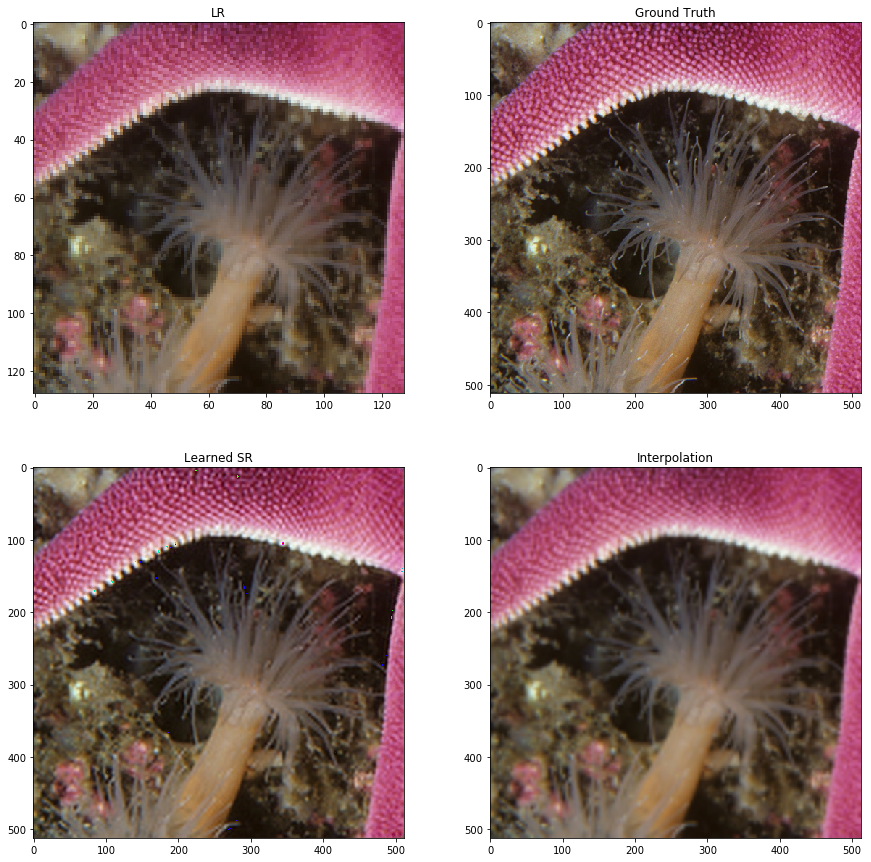

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(221)
#plt.figure(figsize=(10,10))
plt.imshow(ten2np(lr))
plt.title('LR')

plt.subplot(222)
#plt.figure(figsize=(10,10))
plt.title('Ground Truth')
plt.imshow(ten2np(hr))

plt.subplot(223)
#plt.figure(figsize=(10,10))
plt.imshow(hr_img)
plt.title('Learned SR')

plt.subplot(224)
#plt.figure(figsize=(10,10))
plt.imshow(upsample(lr))
plt.title('Interpolation')
